In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import pandas_datareader as pdr 
import matplotlib.pyplot as plt 

In [2]:
def data_mining(ticker):
    pdr_df = pdr.get_data_yahoo(ticker.upper())
    pdr_df.to_csv(r'{ticker_value}.csv'.format(ticker_value=ticker))
    df = pd.read_csv(r'{ticker_value}.csv'.format(ticker_value=ticker), index_col=0, parse_dates=True)
    return df

In [3]:
df = data_mining('tsla')

In [4]:
print(df.head())

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2017-07-18  65.825996  63.132000  63.500000  65.648003  31868500.0  65.648003
2017-07-19  66.330002  64.643997  65.646004  65.052002  31785000.0  65.052002
2017-07-20  66.043999  64.839996  65.379997  65.984001  25831000.0  65.984001
2017-07-21  66.251999  65.160004  65.891998  65.680000  24508000.0  65.680000
2017-07-24  68.680000  66.001999  66.047997  68.503998  43185500.0  68.503998


In [5]:
print(df.tail())

                  High         Low        Open       Close      Volume  \
Date                                                                     
2022-07-12  719.320007  685.109985  710.539978  699.210022  29310300.0   
2022-07-13  726.179993  675.099976  676.500000  711.119995  32651500.0   
2022-07-14  715.960022  688.000000  704.690002  714.940002  26185800.0   
2022-07-15  730.869995  710.669983  720.000000  720.200012  23165500.0   
2022-07-18  750.210022  731.299988  734.809998  741.947998  10534722.0   

             Adj Close  
Date                    
2022-07-12  699.210022  
2022-07-13  711.119995  
2022-07-14  714.940002  
2022-07-15  720.200012  
2022-07-18  741.947998  


In [6]:
print(df.describe())

              High          Low         Open        Close        Volume  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03   
mean    344.734049   328.362790   336.880655   336.791940  4.414430e+07   
std     355.090380   337.803343   346.976384   346.551072  3.005668e+07   
min      37.335999    35.397999    36.220001    35.793999  9.800600e+06   
25%      63.382000    61.052000    62.435001    62.344999  2.519400e+07   
50%      98.851997    90.671997    94.739998    93.811996  3.425700e+07   
75%     687.750000   654.725006   671.195007   671.419983  5.116200e+07   
max    1243.489990  1217.000000  1234.410034  1229.910034  3.046940e+08   

         Adj Close  
count  1259.000000  
mean    336.791940  
std     346.551072  
min      35.793999  
25%      62.344999  
50%      93.811996  
75%     671.419983  
max    1229.910034  


In [7]:
print(df.isnull().any(axis=0))  #No null values.

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool


<AxesSubplot:>

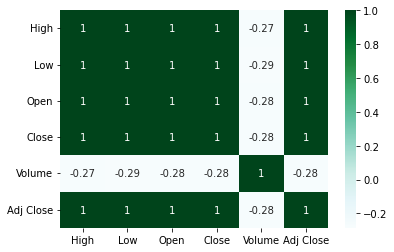

In [8]:
import seaborn as sns
sns.heatmap(df.corr(), cmap = 'BuGn', annot=True)

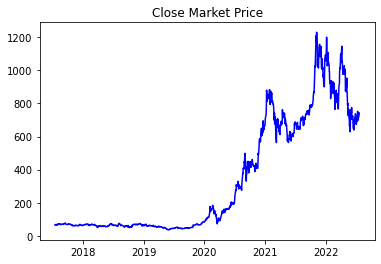

In [9]:
plt.plot(df['Close'], color='blue')
plt.title('Close Market Price')
plt.show()

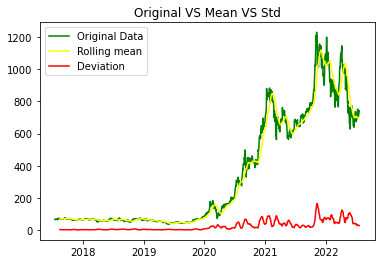

In [10]:
#Getting the moving average and deviation.
data_mean = df['Close'].rolling(window=23).mean()
data_std = df['Close'].rolling(window=23).std()

#Plotting the results.
from matplotlib import pyplot as plt
plt.plot(df['Close'], color='green', label='Original Data')
plt.plot(data_mean, color="yellow", label="Rolling mean")
plt.plot(data_std, color='red', label='Deviation')
plt.legend(loc='best')
plt.title('Original VS Mean VS Std')
plt.show()

In [11]:
df.shape

(1259, 6)

In [12]:
from sklearn.preprocessing import MinMaxScaler
def data_preprocess_and_split(data):

    #Scaling the data.
    scaler = MinMaxScaler(feature_range=(0,1))
    df1 = scaler.fit_transform(np.array(data['Close']).reshape(-1,1))

    train_size = int(len(data) * 0.75)
    test_size = int(len(data) - train_size)
    train_data, test_data = df1[0:train_size,:],df1[train_size:len(df1),:1]
    print(train_size, test_size)
    return scaler, train_data, test_data, df1

In [13]:
m_scaler, x_data, y_data, df1 = data_preprocess_and_split(df)

944 315


In [14]:
def dataset_matrix(dataset, timestep=23):
    '''
    Function to generate a data matrix depending upon the time stamps taken into consideration for the forecasting.
    '''
    X_data, Y_data = [], []
    for i in range(len(dataset)-timestep-1):
        flag_X = dataset[i:(i+timestep), 0]
        flag_Y = dataset[(i+timestep),0]
        X_data.append(flag_X)
        Y_data.append(flag_Y)
    return np.array(X_data), np.array(Y_data)

In [15]:
Xtrain, Ytrain = dataset_matrix(x_data)
Xtest, Ytest = dataset_matrix(y_data)

In [16]:
print(Xtrain.shape,'\n',Ytrain.shape,'\n',Xtest.shape,'\n',Ytest.shape)

(920, 23) 
 (920,) 
 (291, 23) 
 (291,)


In [17]:
#Reshaping the data to feed it into the LSTM model.
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1) 
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

# Bulding the Model.

In [18]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

#Bulding blocks of the model.
model = Sequential()
model.add(LSTM(100,activation='relu',return_sequences=True, input_shape=(23,1)))
model.add(Dropout(0.3))
model.add(LSTM(50,activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50,activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50,activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 23, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 23, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 23, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [19]:
from keras.callbacks import CSVLogger, ModelCheckpoint,EarlyStopping  
csv_logger = CSVLogger('training4.log', separator = ';')
checkpoint = ModelCheckpoint('lstm_model4.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'val_loss', patience = 20)

In [20]:
#Fitting the model with the dataset at hand.
model.fit(Xtrain, Ytrain, validation_data = (Xtest, Ytest), epochs = 100, batch_size = 64,verbose=1, callbacks=[csv_logger, checkpoint])

Epoch 1/100
15/15 [==============================] - 17s 198ms/step - loss: 0.0347 - val_loss: 0.0225

Epoch 00001: val_loss improved from inf to 0.02245, saving model to lstm_model4.h5
Epoch 2/100
15/15 [==============================] - 1s 84ms/step - loss: 0.0104 - val_loss: 0.0938

Epoch 00002: val_loss did not improve from 0.02245
Epoch 3/100
15/15 [==============================] - 1s 84ms/step - loss: 0.0090 - val_loss: 0.0193

Epoch 00003: val_loss improved from 0.02245 to 0.01926, saving model to lstm_model4.h5
Epoch 4/100
15/15 [==============================] - 1s 83ms/step - loss: 0.0057 - val_loss: 0.0230

Epoch 00004: val_loss did not improve from 0.01926
Epoch 5/100
15/15 [==============================] - 1s 89ms/step - loss: 0.0039 - val_loss: 0.0119

Epoch 00005: val_loss improved from 0.01926 to 0.01189, saving model to lstm_model4.h5
Epoch 6/100
15/15 [==============================] - 1s 90ms/step - loss: 0.0036 - val_loss: 0.0087

Epoch 00006: val_loss improved fr

## Evaluation of the Model.

In [21]:
#Predicting values.
train_predict = model.predict(Xtrain)
test_predict = model.predict(Xtest)

In [22]:
#Converting the normalized predictions to their original form.
train_predict = m_scaler.inverse_transform(train_predict)
test_predict = m_scaler.inverse_transform(test_predict)

In [23]:
from keras.losses import MeanSquaredError
metric = MeanSquaredError(reduction='auto', name='mean_squared_error')
print('MSE: ', metric(Ytest, test_predict).numpy())
print('RMSE: ', np.sqrt(metric(Ytest, test_predict).numpy()))


MSE:  600417.9
RMSE:  774.86633


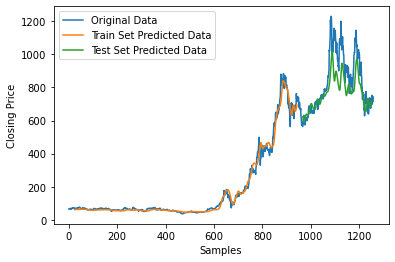

In [24]:
#Evaluation of the model on train and test data.
import matplotlib.pyplot as plt
look_back=23
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(m_scaler.inverse_transform(df1), label='Original Data')
plt.plot(trainPredictPlot, label='Train Set Predicted Data')
plt.plot(testPredictPlot, label='Test Set Predicted Data')
plt.xlabel('Samples')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [25]:
len(y_data)

315

In [26]:
x_input=np.array(y_data[291:]).reshape(1,-1)
x_input.shape

(1, 24)

In [27]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.5120239617401448,
 0.524970744530417,
 0.5553949378340479,
 0.5053997862456494,
 0.5145949073041012,
 0.5655363185641735,
 0.5631496362809594,
 0.5605954558643216,
 0.5873181295383259,
 0.585341784458385,
 0.5545491157065234,
 0.5440643561358909,
 0.5339732197344671,
 0.5409825847112577,
 0.5555624359674716,
 0.5522126777520111,
 0.5843954736734571,
 0.6000220732587485,
 0.5587698437704862,
 0.555570818541131,
 0.5655447011378327,
 0.568743726367188,
 0.5731486665986392,
 0.5913612901578229]

In [28]:
from numpy import array

lst_output=[]
n_steps=23
i=0
while(i<30):
    
    if(len(temp_input))>23:
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.52497074 0.55539494 0.50539979 0.51459491 0.56553632 0.56314964
 0.56059546 0.58731813 0.58534178 0.55454912 0.54406436 0.53397322
 0.54098258 0.55556244 0.55221268 0.58439547 0.60002207 0.55876984
 0.55557082 0.5655447  0.56874373 0.57314867 0.59136129]
0 day output [[0.5725423]]
1 day input [0.55539494 0.50539979 0.51459491 0.56553632 0.56314964 0.56059546
 0.58731813 0.58534178 0.55454912 0.54406436 0.53397322 0.54098258
 0.55556244 0.55221268 0.58439547 0.60002207 0.55876984 0.55557082
 0.5655447  0.56874373 0.57314867 0.59136129 0.57254231]
1 day output [[0.5745264]]
2 day input [0.50539979 0.51459491 0.56553632 0.56314964 0.56059546 0.58731813
 0.58534178 0.55454912 0.54406436 0.53397322 0.54098258 0.55556244
 0.55221268 0.58439547 0.60002207 0.55876984 0.55557082 0.5655447
 0.56874373 0.57314867 0.59136129 0.57254231 0.57452643]
2 day output [[0.5768937]]
3 day input [0.51459491 0.56553632 0.56314964 0.56059546 0.58731813 0.58534178
 0.55454912 0.54406436 0.533973

In [29]:
day_new=np.arange(1,24)
day_pred=np.arange(24,54)

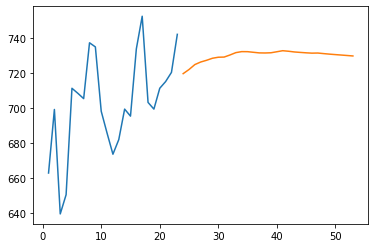

In [32]:
plt.plot(day_new,m_scaler.inverse_transform(df1[1236:]))
plt.plot(day_pred,m_scaler.inverse_transform(lst_output))

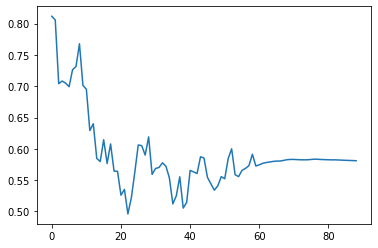

In [33]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

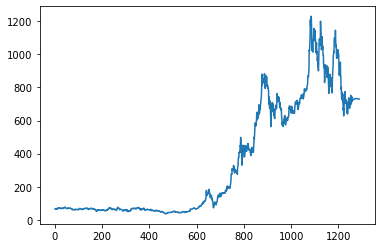

In [34]:
df3=m_scaler.inverse_transform(df3).tolist()
plt.plot(df3)

In [37]:
losses = pd.read_csv('training4.log', delimiter=";")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


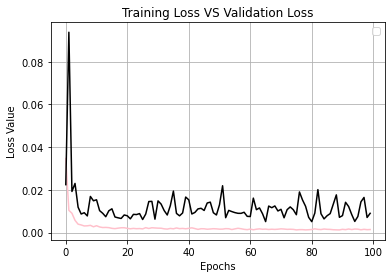

In [41]:
plt.plot(losses['loss'], color='pink')
plt.plot(losses['val_loss'], color='black')
plt.title('Training Loss VS Validation Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(loc='best')
plt.show()